<a href="https://www.kaggle.com/sanjayanbu/titanic-survival-prediction?scriptVersionId=89001575" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, confusion_matrix, plot_roc_curve, roc_curve
from sklearn.svm import SVC
from scipy.stats import reciprocal, uniform
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from keras_tuner import RandomSearch
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

### Reading Data

In [2]:
train_data = pd.read_csv("../input/titanic/train.csv")
test_data = pd.read_csv("../input/titanic/test.csv")

### Checking for NA values

In [3]:
train_test = pd.concat([train_data, test_data], axis=0)

In [4]:
train_test.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

#### Columns with null values are: Age, Cabin, Embarked, Fare

In [5]:
(train_test.isnull().sum() / len(train_test)) * 100

PassengerId     0.000000
Survived       31.932773
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.091673
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.076394
Cabin          77.463713
Embarked        0.152788
dtype: float64

In [6]:
# As Cabin is filled with 77% of null values, We are removing it
train_data.drop(['Cabin'], inplace=True, axis=1, errors='ignore')
test_data.drop(['Cabin'], inplace=True, axis=1, errors='ignore')

In [7]:
# Filling the na values of Age with grouped mean of Pclass and Sex
train_data['Age'].fillna(train_data.groupby(['Pclass', 'Sex'])['Age'].transform('mean'), inplace=True)
test_data['Age'].fillna(test_data.groupby(['Pclass', 'Sex'])['Age'].transform('mean'), inplace=True)

In [8]:
# Filling the na values of Embarked with 'S'
train_data['Embarked'].fillna('S', inplace=True)

In [9]:
# Filling the na values of fare with grouped mean of Pclass and sex
train_data['Fare'].fillna(train_data.groupby(['Pclass', 'Sex'])['Fare'].transform('mean'), inplace=True)
test_data['Fare'].fillna(test_data.groupby(['Pclass', 'Sex'])['Fare'].transform('mean'), inplace=True)

### Checking the number of unique values

In [10]:
(train_test.nunique() / len(train_test)) * 100

PassengerId    100.000000
Survived         0.152788
Pclass           0.229183
Name            99.847212
Sex              0.152788
Age              7.486631
SibSp            0.534759
Parch            0.611154
Ticket          70.970206
Fare            21.466769
Cabin           14.209320
Embarked         0.229183
dtype: float64

In [11]:
# As Ticket is composed of 70% of unique values, we are dropping it
train_data.drop(['Ticket'], inplace=True, errors='ignore', axis=1)
test_data.drop(['Ticket'], inplace=True, errors='ignore', axis=1)

In [12]:
# Gaining Title from Name
train_data['Title'] = train_data['Name'].str.extract(" ([A-Za-z]+)\.", expand=False)
test_data['Title'] = test_data['Name'].str.extract(" ([A-Za-z]+)\.", expand=False)

In [13]:
# Dropping Name
train_data.drop(['Name'], inplace=True, axis=1, errors='ignore')
test_data.drop(['Name'], inplace=True, axis=1, errors='ignore')

### Changing Categorical to Numerical Features

In [14]:
train_data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Sex             object
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Embarked        object
Title           object
dtype: object

In [15]:
# Sex, Title, Embarked are categorical features

# Transforming Sex
train_data.replace({'male': 0, 'female': 1}, inplace=True)
test_data.replace({'male': 0, 'female': 1}, inplace=True)

In [16]:
# Transforming Embarked
train_data['Embarked'].unique()
train_data.replace({'Q': 0, 'C': 0.5, 'S': 1}, inplace=True)
test_data.replace({'Q': 0, 'C': 0.5, 'S': 1}, inplace=True)

In [17]:
# Transforming Title
train_data['Title'].unique()
train_data['Title'].replace({'Dona': 'Mrs'}, inplace=True)
test_data['Title'].replace({'Dona': 'Mrs'}, inplace=True)

ordinal_encoder = OrdinalEncoder()
train_data['Title_Enc'] = ordinal_encoder.fit_transform(train_data[['Title']])
test_data['Title_Enc'] = ordinal_encoder.transform(test_data[['Title']])

# Dropping Title
train_data.drop(['Title'], axis=1, inplace=True, errors='ignore')
test_data.drop(['Title'], axis=1, inplace=True, errors='ignore')

### Featuring new Column

In [18]:
train_data['FS'] = train_data['SibSp'] + train_data['Parch']
test_data['FS'] = test_data['SibSp'] + test_data['Parch']

train_data.drop(['SibSp', 'Parch'], axis=1, inplace=True)
test_data.drop(['SibSp', 'Parch'], axis=1, inplace=True)

### Univariate Analysis

In [19]:
train_data.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title_Enc,FS
0,1,0,3,0,22.0,7.2500,1.0,12.0,1
1,2,1,1,1,38.0,71.2833,0.5,13.0,1
2,3,1,3,1,26.0,7.9250,1.0,9.0,0
3,4,1,1,1,35.0,53.1000,1.0,13.0,1
4,5,0,3,0,35.0,8.0500,1.0,12.0,0


In [20]:
survived = train_data[train_data['Survived'] == 1]
not_survived = train_data[train_data['Survived'] == 0]

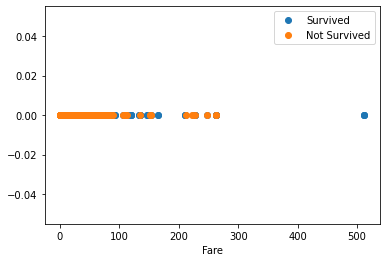

In [21]:
# Fare
plt.plot(survived['Fare'], np.zeros_like(survived['Fare']), 'o', label='Survived')
plt.plot(not_survived['Fare'], np.zeros_like(not_survived['Fare']), 'o', label='Not Survived')
plt.xlabel('Fare')
plt.legend()

# Higher Fare improves the survival

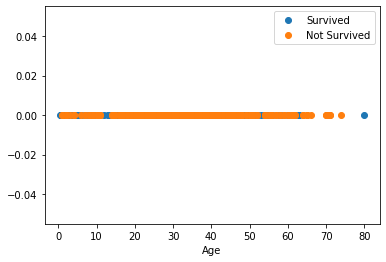

In [22]:
# Age
plt.plot(survived['Age'], np.zeros_like(survived['Age']), 'o', label='Survived')
plt.plot(not_survived['Age'], np.zeros_like(not_survived['Age']), 'o',label='Not Survived')
plt.xlabel('Age')
plt.legend()

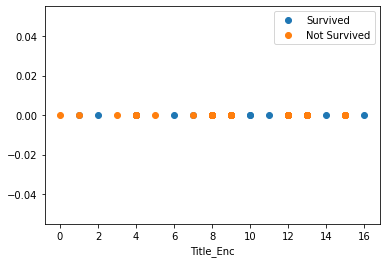

In [23]:
# Title Enc
plt.plot(survived['Title_Enc'], np.zeros_like(survived['Title_Enc']), 'o', label='Survived')
plt.plot(not_survived['Title_Enc'], np.zeros_like(not_survived['Title_Enc']), 'o', label='Not Survived')
plt.xlabel('Title_Enc')
plt.legend()

<AxesSubplot:xlabel='Pclass', ylabel='Count'>

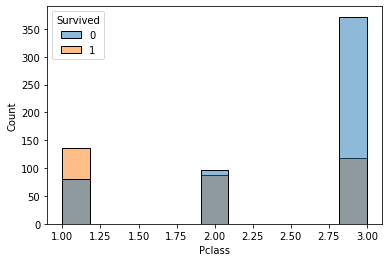

In [24]:
# Pclass
sns.histplot(data=train_data, x='Pclass', hue='Survived')

# Pclass 1 has higher survival than the other two classes

<AxesSubplot:xlabel='Sex', ylabel='Count'>

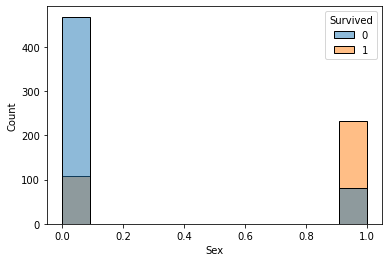

In [25]:
# Sex
sns.histplot(data=train_data, hue='Survived', x='Sex')
# Female has more survival rate than male

<AxesSubplot:xlabel='Embarked', ylabel='Count'>

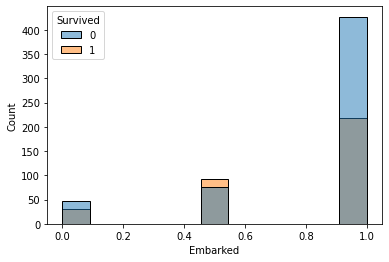

In [26]:
# Embarked
sns.histplot(train_data, x='Embarked', hue='Survived')
# C has more mortality rate than the other two classes

<AxesSubplot:xlabel='Title_Enc', ylabel='Count'>

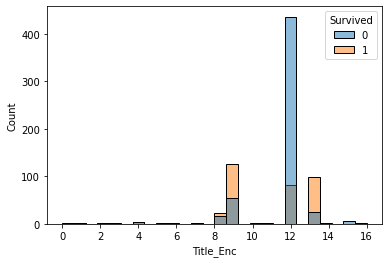

In [27]:
# Title Enc
sns.histplot(train_data, hue='Survived', x='Title_Enc')

### Bivariate Analysis / Multivariate Analysis

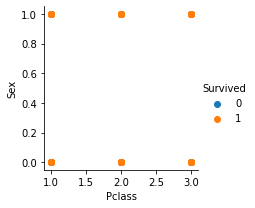

In [28]:
# Pclass and Sex
sns.FacetGrid(train_data, hue='Survived', height=3).map(plt.scatter, 'Pclass', 'Sex').add_legend()
plt.show()

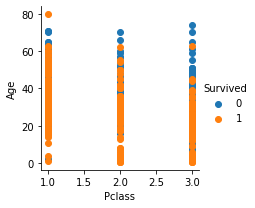

In [29]:
# Pclass and Age
sns.FacetGrid(train_data, hue='Survived', height=3).map(plt.scatter, 'Pclass', 'Age').add_legend()
plt.show()
# Pclass 3 and Age > 40 are mostly not survived

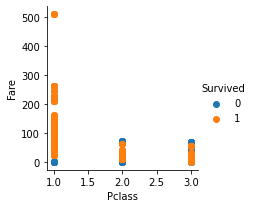

In [30]:
# Pclass and Fare
sns.FacetGrid(data=train_data, hue='Survived', height=3).map(plt.scatter, 'Pclass', 'Fare').add_legend()
# Pclass 1 and Fare > 200 are mostly survived

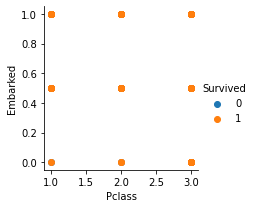

In [31]:
# PClass and Embarked
sns.FacetGrid(train_data, hue='Survived', height=3).map(plt.scatter, 'Pclass', 'Embarked').add_legend()

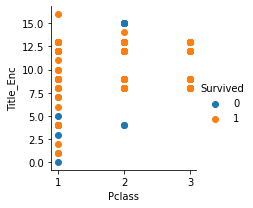

In [32]:
# Pclass and Title
sns.FacetGrid(train_data, hue='Survived', height=3).map(plt.scatter, 'Pclass', 'Title_Enc').add_legend()

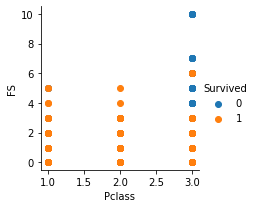

In [33]:
# Pclass and FS
sns.FacetGrid(train_data, hue='Survived', height=3).map(plt.scatter, 'Pclass', 'FS').add_legend()

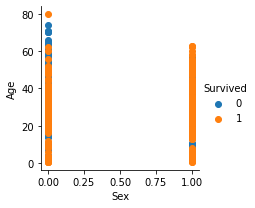

In [34]:
# Sex and Age
sns.FacetGrid(train_data, hue='Survived', height=3).map(plt.scatter, 'Sex', 'Age').add_legend()

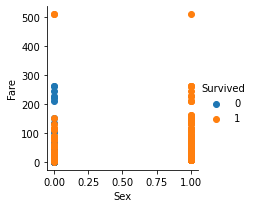

In [35]:
# Sex and Fare
sns.FacetGrid(train_data, hue='Survived', height=3).map(plt.scatter, 'Sex', 'Fare').add_legend()

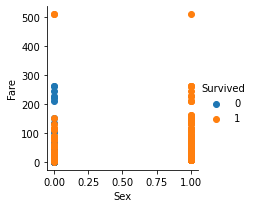

In [36]:
# Sex and Fare 
sns.FacetGrid(train_data, hue='Survived', height=3).map(plt.scatter, 'Sex', 'Fare').add_legend()

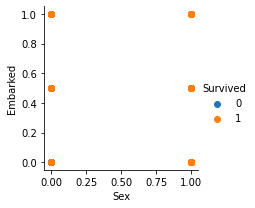

In [37]:
# Sex and Embarked
sns.FacetGrid(train_data, hue='Survived', height=3).map(plt.scatter, 'Sex', 'Embarked').add_legend()

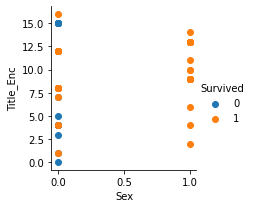

In [38]:
# Sex and Title_Enc
sns.FacetGrid(train_data, hue='Survived', height=3).map(plt.scatter, 'Sex', 'Title_Enc').add_legend()

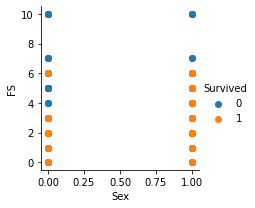

In [39]:
# Sex and FS
sns.FacetGrid(train_data, hue='Survived', height=3).map(plt.scatter, 'Sex', 'FS').add_legend()

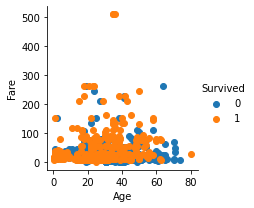

In [40]:
# Age and Fare
sns.FacetGrid(train_data, hue='Survived', height=3).map(plt.scatter, 'Age', 'Fare').add_legend()

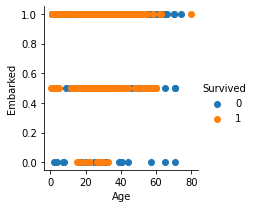

In [41]:
# Age and Embarked
sns.FacetGrid(train_data, hue='Survived', height=3).map(plt.scatter, 'Age', 'Embarked').add_legend()

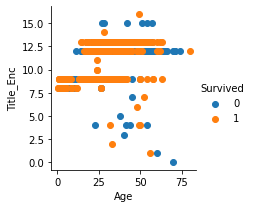

In [42]:
# Age and Title Enc
sns.FacetGrid(train_data, hue='Survived', height=3).map(plt.scatter, 'Age', 'Title_Enc').add_legend()

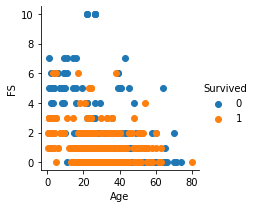

In [43]:
# Age and FS
sns.FacetGrid(train_data, hue='Survived', height=3).map(plt.scatter, 'Age', 'FS').add_legend()

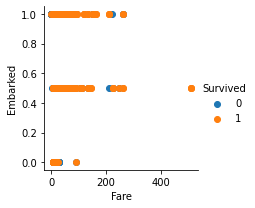

In [44]:
# Fare and Embarked
sns.FacetGrid(train_data, hue='Survived', height=3).map(plt.scatter, 'Fare', 'Embarked').add_legend()

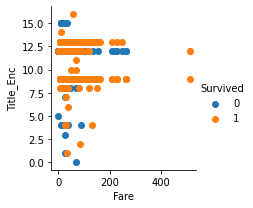

In [45]:
# Fare and Title Enc
sns.FacetGrid(train_data, hue='Survived', height=3).map(plt.scatter, 'Fare', 'Title_Enc').add_legend()

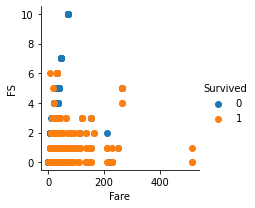

In [46]:
# Fare and FS
sns.FacetGrid(train_data, hue='Survived', height=3).map(plt.scatter, 'Fare', 'FS').add_legend()

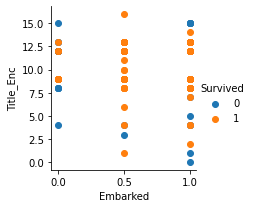

In [47]:
# Embarked and Title Enc
sns.FacetGrid(train_data, hue='Survived', height=3).map(plt.scatter, 'Embarked', 'Title_Enc').add_legend()

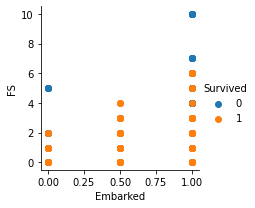

In [48]:
# Embarked and FS
sns.FacetGrid(train_data, hue='Survived', height=3).map(plt.scatter, 'Embarked', 'FS').add_legend()

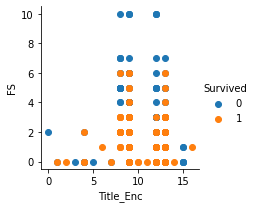

In [49]:
# Title Enc and FS
sns.FacetGrid(train_data, hue='Survived', height=3).map(plt.scatter, 'Title_Enc', 'FS').add_legend()

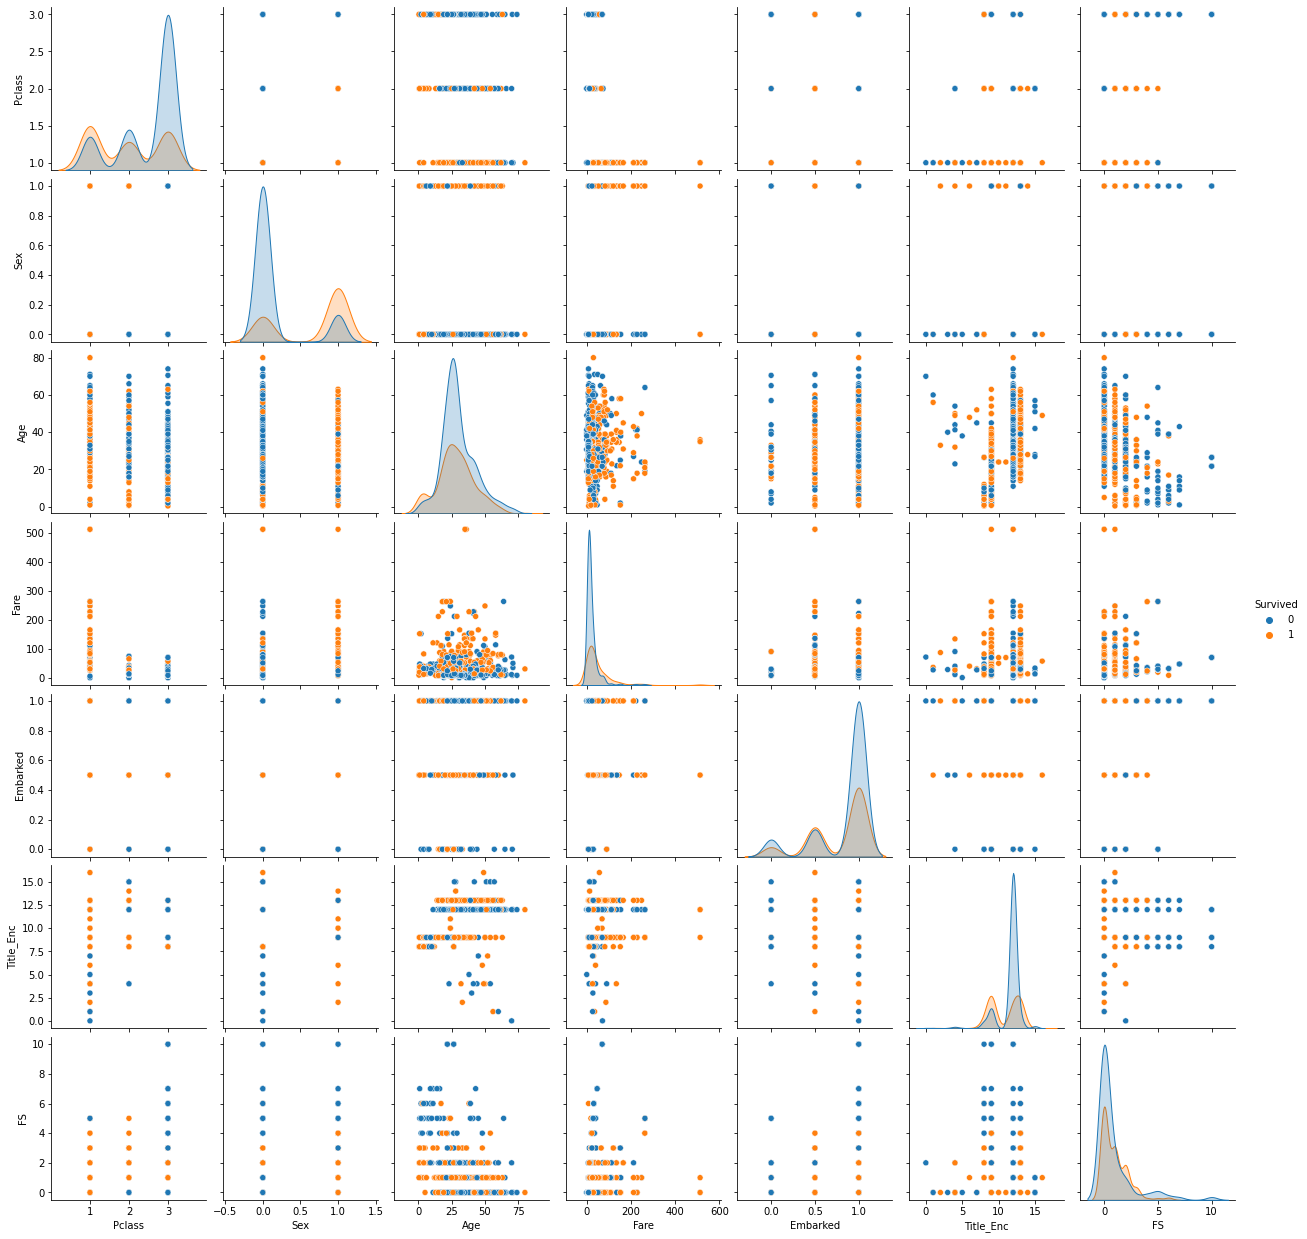

In [50]:
sns.pairplot(train_data.loc[:,train_data.columns != 'PassengerId'], hue='Survived')

### Finding correlation between features

In [51]:
train_data.corr()['Survived']

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Sex            0.543351
Age           -0.067485
Fare           0.257307
Embarked      -0.106811
Title_Enc     -0.201345
FS             0.016639
Name: Survived, dtype: float64

In [52]:
independent_features = ['Pclass', 'Sex', 'Fare', 'Embarked', 'Title_Enc', 'PassengerId']
dependent_features = ['Survived']
filtered_features = list(filter(lambda x:x!= 'PassengerId', independent_features))

### Scaling Features to Standard Normal Distribution

In [53]:
standard_scaler = StandardScaler()
scaled_train = standard_scaler.fit_transform(train_data[filtered_features])
scaled_test = standard_scaler.transform(test_data[filtered_features])
scaled_train = pd.DataFrame(scaled_train, columns=filtered_features)
scaled_test = pd.DataFrame(scaled_test, columns=filtered_features)
scaled_train = scaled_train.assign(PassengerId=train_data['PassengerId'])
scaled_test = scaled_test.assign(PassengerId=test_data['PassengerId'])

In [54]:
x_train, x_test, y_train, y_test = train_test_split(scaled_train[filtered_features], train_data[dependent_features].values.ravel(), random_state=1, test_size=0.3)

### Logistic Regression

In [55]:
np.logspace(-1, 5, num=3)

array([1.e-01, 1.e+02, 1.e+05])

In [56]:
lr_model = LogisticRegression()
lr_model.get_params()
lr_model_params = {'C':np.logspace(1, 3, num=10), 'random_state':[1], 'solver':['liblinear', 'lbfgs'], 'max_iter':[200, 100, 150]}

In [57]:
final_model = lr_model
final_model_params = lr_model_params

### Predicting Accuracy Score

In [58]:
def predict_model():
    cv = GridSearchCV(final_model, final_model_params, cv=5)
    train_model = cv.fit(x_train, y_train)
    best_model = train_model.best_estimator_
    print(train_model.best_params_)
    output_values = best_model.predict(x_test)
    return best_model, output_values

In [59]:
best_model, y_pred = predict_model()
accuracy_score(y_pred, y_test) * 100

{'C': 10.0, 'max_iter': 200, 'random_state': 1, 'solver': 'liblinear'}


74.6268656716418

### Customizing thresholds based on results

Text(0.5, 1.0, 'Threshold 0.5')

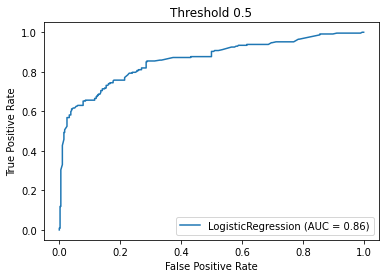

In [60]:
plot_roc_curve(best_model, x_train, y_train)
plt.title('Threshold 0.5')

In [61]:
positive_preds = best_model.predict_proba(x_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train, positive_preds)

In [62]:
optimum_threshold = thresholds[np.argmax(tpr - fpr)]

In [63]:
y_out = (positive_preds > optimum_threshold).astype(int)

In [64]:
accuracy_score(y_out, y_train) 

0.8009630818619583

### SVM

In [65]:
final_model = SVC()

In [66]:
final_model.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [67]:
# final_model_params = {'C':np.logspace(1, 5, num=4), 'random_state':[1], 'kernel': ['rbf', 'sigmoid'], 'gamma':[1, 0.1, 0.01, 0.001, 0.0001, 0.005]}
# best_model, y_pred = predict_model()
# accuracy_score(y_pred, y_test) * 100

### Decision Tree Classifier

In [68]:
final_model.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [69]:
final_model = DecisionTreeClassifier()
final_model_params = {'ccp_alpha': np.logspace(-1, -3, num=15), 'random_state': [1]}

In [70]:
best_model, y_pred = predict_model()

{'ccp_alpha': 0.002682695795279727, 'random_state': 1}


In [71]:
accuracy_score(y_pred, y_test) * 100

79.47761194029852

### Analyzing the tree response

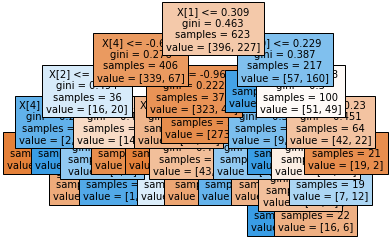

In [72]:
plot_tree(best_model, filled=True, fontsize=10)
plt.rcParams["figure.figsize"] = (15, 15)
plt.show()

### Random Forest Classifier

In [73]:
final_model = RandomForestClassifier()
final_model_params = {'ccp_alpha': np.logspace(-1, -3, num=4), 'random_state':[1]}

In [74]:
final_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [75]:
best_model, y_pred = predict_model()

{'ccp_alpha': 0.004641588833612782, 'random_state': 1}


In [76]:
accuracy_score(y_test, y_pred) * 100

78.35820895522389

### Analyzing the tree response

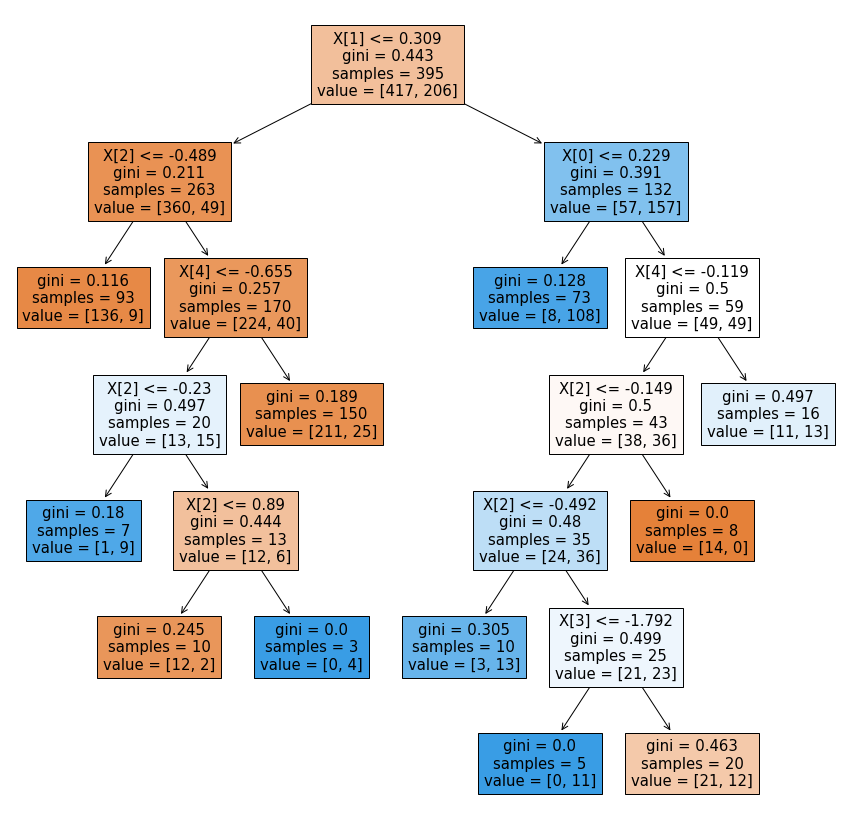

In [77]:
plot_tree(best_model.estimators_[0], filled=True)
plt.rcParams['figure.figsize'] = (15, 15)
plt.show()

In [78]:
plt.rcParams['figure.figsize'] = (6.5, 3.4)

### Ada Boost Classifier

In [79]:
final_model = AdaBoostClassifier()
final_model_params = {'learning_rate': [0.5, 0.8], 'n_estimators': [50, 78], 'random_state': [1]}

In [80]:
best_model, y_pred = predict_model()

{'learning_rate': 0.5, 'n_estimators': 50, 'random_state': 1}


In [81]:
accuracy_score(y_pred, y_test) * 100

77.23880597014924

### Analyzing Stump 

[Text(181.35, 138.618, 'X[1] <= 0.309\ngini = 0.463\nsamples = 623\nvalue = [0.636, 0.364]'),
 Text(90.675, 46.20599999999999, 'gini = 0.276\nsamples = 406\nvalue = [0.544, 0.108]'),
 Text(272.025, 46.20599999999999, 'gini = 0.387\nsamples = 217\nvalue = [0.091, 0.257]')]

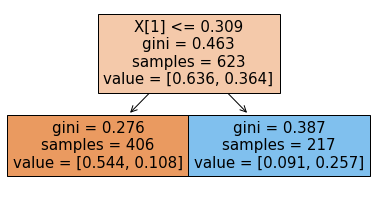

In [82]:
plot_tree(best_model.estimators_[0], filled=True)

### Gradient Boosing

In [83]:
final_model = GradientBoostingClassifier()
final_model_params = {'max_depth':[2, 3, 5],'ccp_alpha': np.logspace(-1, -4, num=5), 'random_state':[1], 'n_estimators': [100, 150, 283], 'init': [AdaBoostClassifier(), RandomForestClassifier(), DecisionTreeClassifier(), 0]}

In [84]:
final_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [85]:
best_model, y_pred = predict_model()

{'ccp_alpha': 0.0005623413251903491, 'init': AdaBoostClassifier(), 'max_depth': 2, 'n_estimators': 100, 'random_state': 1}


In [86]:
accuracy_score(y_pred, y_test)

0.7835820895522388

### Xgboost Classifier

In [87]:
final_model = XGBClassifier()
final_model_params = {'random_state':[1], 'booster':['gbtree', 'gblinear', 'dart'], 'n_estimators':[100, 250]}

In [88]:
best_model, y_pred = predict_model()

[06:01:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:01:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:01:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:01:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [89]:
accuracy_score(y_test, y_pred)

0.8246268656716418

In [90]:
final_model.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'enable_categorical': False,
 'gamma': None,
 'gpu_id': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

### Simple ANN without hyperparameter tuning

In [91]:
keras_model = Sequential()
keras_model.add(Dense(input_dim=5, units=6, kernel_initializer='he_uniform', activation='relu'))
keras_model.add(Dropout(0.4))
keras_model.add(Dense(units=8, kernel_initializer='he_normal', activation='relu'))
keras_model.add(Dropout(0.2))
keras_model.add(Dense(units=4, kernel_initializer='he_normal', activation='relu'))
keras_model.add(Dense(units=1, activation='sigmoid', kernel_initializer='glorot_uniform'))


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

In [92]:
keras_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [93]:
keras_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=20)

2022-03-01 06:01:38.773327: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
32/32 [==============================] - 1s 13ms/step - loss: 0.8439 - accuracy: 0.5698 - val_loss: 0.7387 - val_accuracy: 0.5634
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 0.7670 - accuracy: 0.6164 - val_loss: 0.7240 - val_accuracy: 0.5634
Epoch 3/100
32/32 [==============================] - 0s 4ms/step - loss: 0.7452 - accuracy: 0.6645 - val_loss: 0.7110 - val_accuracy: 0.5597
Epoch 4/100
32/32 [==============================] - 0s 5ms/step - loss: 0.7237 - accuracy: 0.6758 - val_loss: 0.6990 - val_accuracy: 0.5784
Epoch 5/100
32/32 [==============================] - 0s 5ms/step - loss: 0.6861 - accuracy: 0.6758 - val_loss: 0.6914 - val_accuracy: 0.6082
Epoch 6/100
32/32 [==============================] - 0s 5ms/step - loss: 0.7219 - accuracy: 0.6533 - val_loss: 0.6838 - val_accuracy: 0.6082
Epoch 7/100
32/32 [==============================] - 0s 5ms/step - loss: 0.6716 - accuracy: 0.6838 - val_loss: 0.6742 - val_accuracy: 0.6082
Epoch 8/100


In [94]:
output_keras = best_model.predict(scaled_test[filtered_features])

In [95]:
keras_classification = (output_keras > 0.5).astype(int).reshape(-1,)

In [96]:
passenger_id = test_data['PassengerId'].values

In [97]:
passenger_id.shape, keras_classification.shape

((418,), (418,))

In [98]:
submission_df = pd.DataFrame({'PassengerId':passenger_id, 'Survived':keras_classification})

In [99]:
def make_ann_keras(hp):
    model = Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(Dense(units=hp.Int(f'units_{str(i)}', min_value=2, max_value=1024, step=32), activation='relu'))
    model.add(Dense(units=1, activation='sigmoid', kernel_initializer='glorot_normal'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), metrics=['accuracy'])
    return model

In [100]:
tuner = RandomSearch(make_ann_keras, objective='val_accuracy', max_trials=10, executions_per_trial=1, directory='project', project_name='Titanic Classification')

In [101]:
tuner.search(x_train, y_train, epochs=25, validation_data=(x_test, y_test))
best_model = tuner.get_best_models()[0]

Trial 10 Complete [00h 00m 19s]
val_accuracy: 0.7910447716712952

Best val_accuracy So Far: 0.7947761416435242
Total elapsed time: 00h 02m 06s


In [102]:
tuner.results_summary()

Results summary
Results in project/Titanic Classification
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
num_layers: 6
units_0: 194
units_1: 770
learning_rate: 0.001
units_2: 610
units_3: 642
units_4: 226
units_5: 162
units_6: 354
units_7: 194
units_8: 642
units_9: 2
Score: 0.7947761416435242
Trial summary
Hyperparameters:
num_layers: 14
units_0: 578
units_1: 834
learning_rate: 0.0001
units_2: 450
units_3: 802
units_4: 802
units_5: 546
units_6: 866
units_7: 962
units_8: 194
units_9: 290
units_10: 226
units_11: 162
units_12: 130
units_13: 386
units_14: 994
units_15: 162
units_16: 610
units_17: 226
units_18: 578
Score: 0.7910447716712952
Trial summary
Hyperparameters:
num_layers: 16
units_0: 450
units_1: 34
learning_rate: 0.001
units_2: 994
units_3: 194
units_4: 482
units_5: 226
units_6: 98
units_7: 642
units_8: 930
units_9: 322
units_10: 706
units_11: 34
units_12: 514
units_13: 34
units_14: 962
units_15: 770
units_16: 706
units_17: 

### Pytorch ANN

In [103]:
x_train_tensor = torch.FloatTensor(x_train.values)
x_test_tensor = torch.FloatTensor(x_test.values)
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

In [104]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.ff1 = nn.Linear(5, 10)
        self.ff2 = nn.Linear(10, 25)
        self.ff3 = nn.Linear(25, 35)
        self.out = nn.Linear(35, 2)
    def forward(self, x):
        x = F.relu(self.ff1(x))
        x = F.relu(self.ff2(x))
        x = F.relu(self.ff3(x))
        x = self.out(x)
        return x

In [105]:
model = NeuralNetwork()
model.parameters

<bound method Module.parameters of NeuralNetwork(
  (ff1): Linear(in_features=5, out_features=10, bias=True)
  (ff2): Linear(in_features=10, out_features=25, bias=True)
  (ff3): Linear(in_features=25, out_features=35, bias=True)
  (out): Linear(in_features=35, out_features=2, bias=True)
)>

In [106]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [107]:
losses = []
epochs = 500
for i in range(epochs):
    y_pred = model.forward(x_train_tensor)
    loss = loss_function(y_pred, y_train_tensor)
    losses.append(loss.item())
    if i % 10 == 1:
        print(f'At Epoch {i}, loss : {loss}')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

At Epoch 1, loss : 0.7171561121940613
At Epoch 11, loss : 0.5270810723304749
At Epoch 21, loss : 0.4093567132949829
At Epoch 31, loss : 0.3835872709751129
At Epoch 41, loss : 0.37299609184265137
At Epoch 51, loss : 0.3673197627067566
At Epoch 61, loss : 0.3614680767059326
At Epoch 71, loss : 0.35488206148147583
At Epoch 81, loss : 0.3483015298843384
At Epoch 91, loss : 0.34374937415122986
At Epoch 101, loss : 0.3393837511539459
At Epoch 111, loss : 0.3356659412384033
At Epoch 121, loss : 0.33128127455711365
At Epoch 131, loss : 0.32737767696380615
At Epoch 141, loss : 0.32410305738449097
At Epoch 151, loss : 0.3207663595676422
At Epoch 161, loss : 0.3166276514530182
At Epoch 171, loss : 0.31708022952079773
At Epoch 181, loss : 0.3143278956413269
At Epoch 191, loss : 0.31206855177879333
At Epoch 201, loss : 0.30958259105682373
At Epoch 211, loss : 0.30818507075309753
At Epoch 221, loss : 0.30650681257247925
At Epoch 231, loss : 0.30490848422050476
At Epoch 241, loss : 0.3082902431488037

Text(0, 0.5, 'Loss')

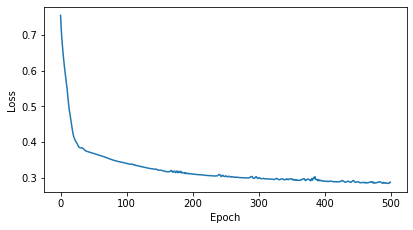

In [108]:
plt.plot(range(epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

### Validation against x_test

In [109]:
final_pred = []
for i, data in enumerate(x_test_tensor):
    y_pred = model(data)
    final_pred.append(y_pred.argmax().item())

In [110]:
accuracy_score(final_pred, y_test)

0.7686567164179104

### Predicting against Test

In [111]:
tensor_input = torch.Tensor(scaled_test[filtered_features].values)

In [112]:
test_output = []
for i, data in enumerate(tensor_input):
    y_pred = model(data)
    test_output.append(y_pred.argmax().item())

In [113]:
submission_df = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived': test_output})

In [114]:
submission_df.to_csv('titanic_survival.csv', index=False)

### Submitting for test data in Kaggle

In [115]:
test_output = best_model.predict(scaled_test[filtered_features]).reshape(-1, )

In [116]:
test_output = (test_output > 0.5).astype(int)

In [117]:
submission_df = pd.DataFrame({'PassengerId': test_data['PassengerId'].values, 'Survived': test_output})

In [118]:
submission_df.to_csv('titanic_survival.csv', index=False)

In [119]:
submission_df

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
